# Computer Vision and Deep Learning - Laboratory 4
 
The main objective of this laboratory is to familiarize you with the training process of a neural network. More specifically, you'll follow this ["recipe"](!http://karpathy.github.io/2019/04/25/recipe/) for training  neural networks proposed by Andrew Karpathy.
You'll go through all the steps of training, data preparation, debugging, hyper-parameter tuning.
 
In the second part of the laboratory, you'll experiment with _transfer learning_ and _fine-tuning_.  Transfer learning is a concept from machine learning which allows you to reuse the knowledge gained while solving a problem (in our case the CNN weights) and applying it to solve a similar problem. This is useful when you are facing a classification problem with a small training dataset.


In [1]:
import time

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import cv2.cv2 as cv2
import glob
from PIL import Image


color = 'red'
plt.rcParams['text.color'] = color
plt.rcParams['axes.labelcolor'] = color
plt.rcParams['xtick.color'] = color
plt.rcParams['ytick.color'] = color
print("done")

done


# Data loading. Training a neural network. Tuning hyper-parameters. 

Your task for the first part of the laboratory is to train a convolutional nerual network for image classification. You can choose any dataset for image classification. By default you can use the [Oxford Pets dataset](!https://www.robots.ox.ac.uk/~vgg/data/pets/), but you can choose a dataset that you will be using for your project or an interesting dataset from [Kaggle](!https://www.kaggle.com/datasets?search=image).

So the first step would be download your training data.

In [ ]:
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz # replace it with the link to the dataset that you will be using
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz 

!tar -xvf images.tar.gz
!tar -xvf annotations.tar.gz 

## Data loading 
 
Up until now, we could load the data to train our model in a single line of code: we just used numpy.load to read the entire training and test sets into memory.
However, in some cases we won't be able to fit all the data into the memory due to hardware constraints.
 
To alleviate this problem, we'll use the [_Sequence_](!https://www.tensorflow.org/api_docs/python/tf/keras/utils/Sequence) class from tensorflow which allows us to feed data to our models.
To write a custom data generator, you'll have to 
- write a class that inherits from the class _Sequence_
- override the \_\_len\_\_ method: this method should return the number of batches in a sequence. In this method you can just return the value:
\begin{equation}
len = \frac{training\_samples}{batch\_size}
\end{equation}
- override the \_\_get_item\_\_(self, index) method: this should return a complete batch;
- optionally, you can override other methods, such as on_epoch_end(). For example, here you could shuffle the data after each epoch.
 
What's nice about this is that when calling the fit() method on a model with a _Sequence_, you can set the use_multiprocessing to True and use several workers that will generate the training batches in parallel.
 
``
fit(
    x=None, y=None, batch_size=None, epochs=1, verbose='auto',
    callbacks=None, validation_split=0.0, validation_data=None, shuffle=True,
    class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None,
    validation_steps=None, validation_batch_size=None, validation_freq=1,
    max_queue_size=10, workers=1, use_multiprocessing=False
)
``
 
Start by writing a custom data generator for the dataset that you chose.

In [5]:
import threading
def run_task(items, target, args):
    """
    Splits items in several batches and runs target with args on each batch in parallel
    (on same number of threads as cpu cores)
    """
    chunk = len(items) // os.cpu_count()
    threads = []
    for startIndex in range(0, os.cpu_count()):
        if startIndex == os.cpu_count() - 1:
            filesToProcess = items[startIndex * chunk:]
        else:
            filesToProcess = items[startIndex * chunk: (startIndex + 1) * chunk]
        thread = threading.Thread(target=target, args=[filesToProcess] + args)
        threads.append(thread)
        thread.start()
    for t in threads:
        t.join()


In [91]:
#for i in range(43):
#    os.makedirs(f"./data/preprocessed/Train/{i}")

In [101]:
def square_image(image):
    width_pad = 0
    height_pad = 0
    if image.shape[0] > image.shape[1]:
        width_pad = (image.shape[0] - image.shape[1])//2
    else:
        height_pad = (image.shape[1] - image.shape[0])//2
    return np.pad(image, ((height_pad, height_pad), (width_pad, width_pad), (0, 0)), mode="edge")

def resize_image(path, shape):
    image = cv2.imread(path)
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = square_image(image)
    return cv2.resize(image, shape)

def worker(images, shape):
    for fileName in images:
        img = resize_image(f"./data/{fileName}", shape)
        cv2.imwrite(f"./data/preprocessed/{fileName}", img)

#images = os.listdir("images")
#run_task(images, worker, [(128, 128)])
#worker(images)

def process_images():
    images = []
    with open("./data/Train.csv") as f:
        for line in f.readlines()[1:]:
            images.append(line.split(",")[-1][:-1])
    print(len(images))
    with open("./data/Test.csv") as f:
        for line in f.readlines()[1:]:
            images.append(line.split(",")[-1][:-1])

    print(len(images))
    print(images[0], images[-1])
    #run_task(images, worker, [(32, 32)])
    print("done")



39209
Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path

39209
Train/20/00020_00000_00000.png Train/42/00042_00007_00029.png
done


In [31]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, labels_file, label_names_file, batch_size, input_shape,
                 shuffle=True, limit_batches=None):
        # TODO your initialization
        # you might want to store the parameters into class variables
        self.input_shape = input_shape
        self.batch_size = batch_size
        self.shuffle = shuffle
        # load the data from the root directory
        self.class_names = {}
        with open(label_names_file) as f:
            for line in f.readlines()[1:]:
                class_id, name = line.split(",")
                self.class_names[int(class_id)] = name
        self.num_classes = len(self.class_names)
        self.limit_batches = limit_batches
        self.data, self.labels = self.get_data(labels_file)
        self.indices = np.arange(len(self.data))
        self.on_epoch_end()

    def get_data(self, labels_file):
        """"
        Loads the paths to the images and their corresponding labels from the database directory
        """
        # TODO your code here
        self.data = []
        self.labels = []
        with open(labels_file) as f:
            lines = f.readlines()[1:]
            if self.limit_batches is not None:
                self.shuffle = False
                np.random.shuffle(lines)
                lines = lines[:self.limit_batches*self.batch_size]

            for line in lines:
                class_id, path = line.split(",")[-2:]
                self.data.append(labels_file[:labels_file.rfind("/")] + "/" + path[:-1])
                self.labels.append(int(class_id))
        return self.data, np.asarray(self.labels)

    def __len__(self):
        """
        Returns the number of batches per epoch: the total size of the dataset divided by the batch size
        """
        return int(np.ceil(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        """"
        Generates a batch of data
        """
        batch_indices = self.indices[index*self.batch_size : (index+1)*self.batch_size]
        batch_x = [] # TODO load the image from batch_indices
        for i in batch_indices:
            image = cv2.imread(self.data[i])
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            batch_x.append(image)
        batch_y = self.labels[batch_indices] # TODO load the corresponding labels of the images you loaded
        # optionally you can use: batch_y = tf.keras.utils.to_categorical(batch_y, num_classes=self.num_classes)
        #return (np.asarray(batch_x)-82.42)/69.06, np.asarray(batch_y)
        #return np.asarray(batch_x), np.asarray(batch_y)
        return np.asarray(batch_x)/255.0, np.asarray(batch_y)

    def on_epoch_end(self):
        """"
        Called at the end of each epoch
        """
        # if required, shuffle your data after each epoch
        self.indices = np.arange(len(self.data))
        if self.shuffle:
            # TODO shuffle data
            # you might find np.random.shuffle useful here
            np.random.shuffle(self.indices)


Now let's look at some images and samples from our data generator.

In [3]:
input_shape = (32,32,3)

PATH_TO_DATA = "C:\\Users\\Dragos\\datasets\\GRTSB\\preprocessed"

In [109]:
train_generator = DataGenerator(f"{PATH_TO_DATA}/Train.csv", f"{PATH_TO_DATA}/label_names.csv", 32, input_shape)
val_generator = DataGenerator(f"{PATH_TO_DATA}/Test.csv", f"{PATH_TO_DATA}/label_names.csv", 32, input_shape)
all = []
for i in range(len(train_generator)):
    batch_x, batch_y = train_generator[i]
    all.append(batch_x)
for i in range(len(val_generator)):
    batch_x, batch_y = val_generator[i]
    all.append(batch_x)
all = np.concatenate(all)
print(all.shape)
print(np.mean(all), np.std(all))
print("done")

(51839, 32, 32, 3)
82.42829359214949 69.06894096078324
done


Time to create generator: 0.0690147876739502
Time to load batch: 0.0
98.38262939453125 78.11642334289098


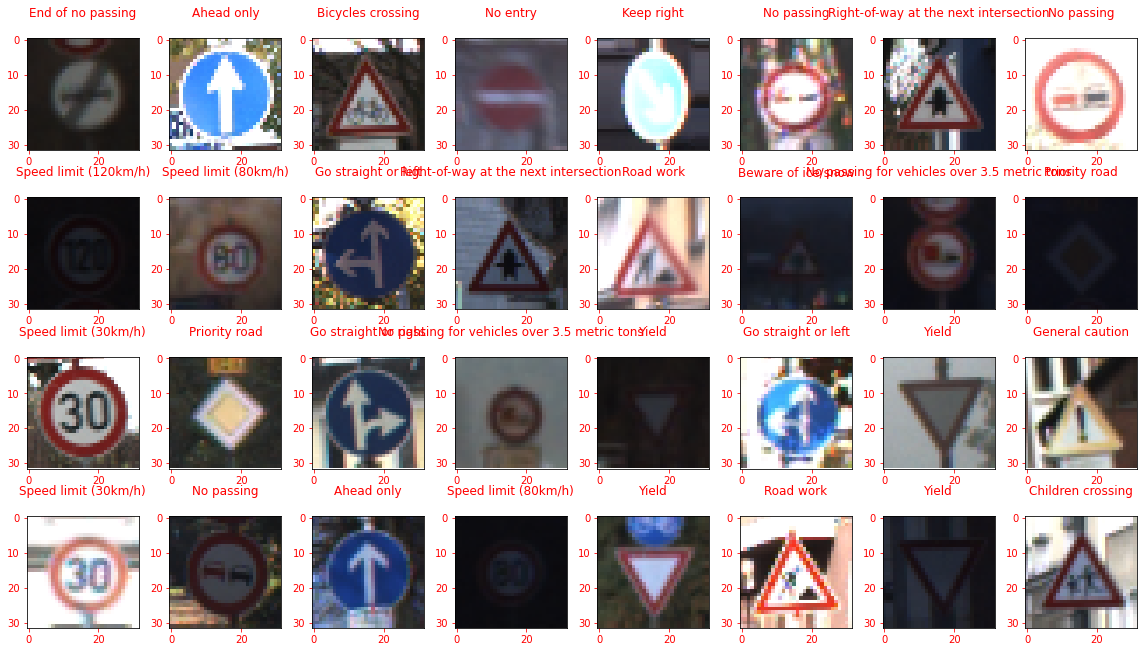

In [20]:
import time


start = time.time()
train_generator = DataGenerator(f"{PATH_TO_DATA}/Train.csv", f"{PATH_TO_DATA}/label_names.csv", 32, (32, 32, 3), 37)
print(f"Time to create generator: {time.time() - start}")
label_names = train_generator.class_names
start = time.time()
batch_x, batch_y = train_generator[5]
print(f"Time to load batch: {time.time()-start}")
print(np.mean(batch_x), np.std(batch_x))

fig, axes = plt.subplots(nrows=4, ncols=8, figsize=[16, 9])
for i in range(axes.shape[0]):
    for j in range(axes.shape[1]):
        axes[i][j].set_title(label_names[batch_y[i*axes.shape[1]+j]])
        axes[i][j].imshow(batch_x[i*axes.shape[1]+j])

plt.tight_layout()
plt.show()

(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)


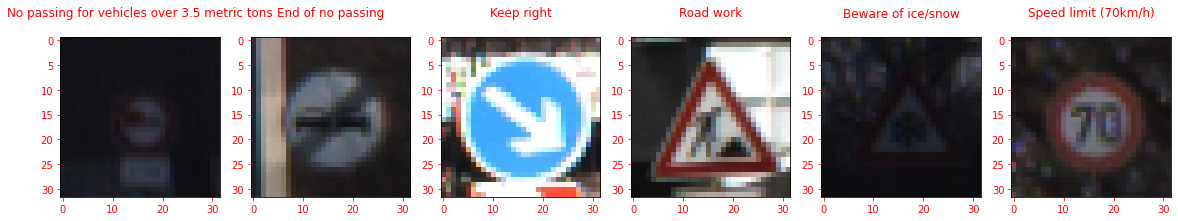

In [21]:
validation_generator = DataGenerator(f"{PATH_TO_DATA}/Test.csv", f"{PATH_TO_DATA}/label_names.csv", 32, input_shape)
label_names = validation_generator.class_names
batch_x, batch_y = validation_generator[0]

fig, axes = plt.subplots(nrows=1, ncols=6, figsize=[16, 9])
for i in range(len(axes)):
    axes[i].set_title(label_names[batch_y[i]])
    axes[i].imshow(batch_x[i])
    print(batch_x[i].shape)
plt.tight_layout()
plt.show()


# CNN architecture

Write a simple tensorflow architecture for a convolutional neural network.
Use the [functional](!https://www.tensorflow.org/guide/keras/functional) api when writing the model.


In [223]:
from tensorflow.keras.layers import Conv2D, Dense, Add, Input, GlobalAvgPool2D, MaxPool2D, Flatten, AveragePooling2D, Dropout
from tensorflow.keras.models import Model
import tensorflow.keras as K

def resnet_block(input, filter_size=3, no_filters=16, initializer = None):
    layer1 = Conv2D(kernel_size=filter_size, filters=no_filters, padding="same", activation="relu", kernel_initializer=initializer)(input)
    layer2 = Conv2D(kernel_size=filter_size, filters=no_filters, padding="same", activation="relu", kernel_initializer=initializer)(layer1)
    return Add()([input, layer2])

def resize_block(input, filter_size=3, no_filters=16, initializer = None):
    layer1 = Conv2D(kernel_size=filter_size, filters=no_filters, strides=2, activation="relu", kernel_initializer=initializer)(input)
    layer2 = Conv2D(kernel_size=filter_size, filters=no_filters, padding="same", activation="relu", kernel_initializer=initializer)(layer1)
    #resizedInput = Conv2D(kernel_size=1, filters=no_filters, strides=2, activation="relu", kernel_initializer=initializer)(input)
    #resized_input = AveragePooling2D(pool_size=(2,2), strides=2)(input)
    return Add()([layer1, layer2])

def build_mini_resnet(input_size, num_classes):
    initializer = None#K.initializers.HeNormal()
    inputs = Input(shape=input_size)

    x = Conv2D(kernel_size=3, filters=32, padding="same", activation="relu", kernel_initializer=initializer)(inputs)
    x = resnet_block(x, no_filters=32)
    x = resnet_block(x, no_filters=32)
    x = resnet_block(x, no_filters=32)

    x = resize_block(x, no_filters=64)
    x = resnet_block(x, no_filters=64)
    x = resnet_block(x, no_filters=64)
    x = resnet_block(x, no_filters=64)

    x = resize_block(x, no_filters=128)
    x = resnet_block(x, no_filters=128)
    x = resnet_block(x, no_filters=128)
    x = resnet_block(x, no_filters=128)
    x = resnet_block(x, no_filters=128)
    x = resnet_block(x, no_filters=128)

    x = resize_block(x, no_filters=256)
    x = resnet_block(x, no_filters=256)
    x = resnet_block(x, no_filters=256)
    x = GlobalAvgPool2D()(x)

    # x = Dense(64, activation="relu", kernel_initializer=initializer)(x)
    # x = Dense(64, activation="relu", kernel_initializer=initializer)(x)
    x = Dense(num_classes, activation="relu", kernel_initializer=initializer)(x)
    return Model(inputs=inputs, outputs=x, name="mini_resnet")


def build_mini_vgg(input_size, num_classes):
    initializer = None # K.initializers.HeNormal()
    inputs = Input(shape=input_size)
    x = Conv2D(kernel_size=3, filters=64, activation="relu", padding="same", kernel_initializer=initializer)(inputs)

    x = MaxPool2D(pool_size=(2, 2), strides=2)(x)
    x = Conv2D(kernel_size=3, filters=128, activation="relu", padding="same", kernel_initializer=initializer)(x)

    x = MaxPool2D(pool_size=(2, 2), strides=2)(x)
    x = Conv2D(kernel_size=3, filters=256, activation="relu", padding="same", kernel_initializer=initializer)(x)
    x = Conv2D(kernel_size=3, filters=256, activation="relu", padding="same", kernel_initializer=initializer)(x)

    #x = MaxPool2D(pool_size=(2, 2), strides=2)(x)
    #x = Conv2D(kernel_size=3, filters=512, activation="relu", padding="same", kernel_initializer=initializer)(x)
    #x = Conv2D(kernel_size=3, filters=512, activation="relu", padding="same", kernel_initializer=initializer)(x)

    x = GlobalAvgPool2D()(x)

    #x = MaxPool2D(pool_size=(2, 2), strides=2)(inputs)
    #x = Flatten()(x)
    x = Dense(256, activation="relu", kernel_initializer=initializer)(x)
    x = Dense(num_classes, activation="relu", kernel_initializer=initializer)(x)
    return Model(inputs=inputs, outputs=x, name="mini_vgg")

def build_simple_model(input_size, num_classes):
    initializer = None # K.initializers.HeNormal()
    inputs = Input(shape=input_size)

    x = Conv2D(kernel_size=3, filters=16, activation="relu", kernel_initializer=initializer)(inputs)

    x = resnet_block(x, no_filters=16)
    x = resnet_block(x, no_filters=16)

    x = Conv2D(kernel_size=3, filters=32, strides=2, activation="relu", kernel_initializer=initializer)(x)

    x = resnet_block(x, no_filters=32)
    x = resnet_block(x, no_filters=32)

    #x = Conv2D(kernel_size=3, filters=32, activation="relu", strides=2, kernel_initializer=initializer)(x)

    #x = Conv2D(kernel_size=3, filters=64, activation="relu", strides=2, padding="same", kernel_initializer=initializer)(x)
    #x = resnet_block(x, no_filters=64)
    #x = resnet_block(x, no_filters=64)

    #x = GlobalAvgPool2D()(x)

    x = Flatten()(x)
    #x = Dense(256, activation="relu", kernel_initializer=initializer)(x)
    x = Dense(num_classes, activation="relu", kernel_initializer=initializer)(x)
    return Model(inputs=inputs, outputs=x, name="simple_model")


model = build_simple_model(input_shape, 43)
model.summary()
del model

Model: "simple_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_187 (InputLayer)          [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_1277 (Conv2D)            (None, 30, 30, 16)   448         input_187[0][0]                  
__________________________________________________________________________________________________
conv2d_1278 (Conv2D)            (None, 30, 30, 16)   2320        conv2d_1277[0][0]                
__________________________________________________________________________________________________
conv2d_1279 (Conv2D)            (None, 30, 30, 16)   2320        conv2d_1278[0][0]                
_______________________________________________________________________________________

## Training and fine-tuning

Start by reading this blog [post](!http://karpathy.github.io/2019/04/25/recipe/), such that you can get an idea of the pipeline that you'll have to follow when training a model.

- Triple check that your data loading is correct. (Analyse your data.)
- Check that the setup is correct.
- Overfit a simple network.
- Add regularizations.
  - data augmentation
  - weight decay

Finetune the learning rate. Use learning rate decay; here in the [documentation](!https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/LearningRateSchedule) you have an example on how you can use a learning rate scheduler in tensorflow.

You should have at least 7 different trainings. Plot all the training history.

__Save all your models and their training history!__ 


Create a google spreadsheet or a markdown table in this notebook, and report the configuration and the accuracy for all these trains. 

### Other useful videos (bias and variance, basic recipe for training a deep NN)
- https://www.youtube.com/watch?v=NUmbgp1h64E 
- https://www.youtube.com/watch?v=SjQyLhQIXSM&list=PLkDaE6sCZn6Hn0vK8co82zjQtt3T2Nkqc&index=2 
- https://www.youtube.com/watch?v=C1N_PDHuJ6Q&list=PLkDaE6sCZn6Hn0vK8co82zjQtt3T2Nkqc&index=3 




In [10]:
def plot_history(history):
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='upper right')

    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label = 'val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    #plt.ylim([0, 1])
    plt.legend(loc='upper right')

In [204]:
# TODO your trains here
class CustomLearningRateCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = None):
        print(f"\n{epoch+1} lr: {tf.keras.backend.get_value(self.model.optimizer.learning_rate)}")

def train(build_model, epochs=40, batch_size=64, input_shape=input_shape, limit_batches=None, learning_rate=3e-4, lr_scheduler=None):
    print(f"Epochs: {epochs}\nBatch size: {batch_size}")
    if lr_scheduler is None:
        lr_schedule = K.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=learning_rate,
            decay_steps=epochs,
            decay_rate=0.96)
    else:
        lr_schedule = lr_scheduler


    train_generator = DataGenerator(f"{PATH_TO_DATA}/Train.csv", f"{PATH_TO_DATA}/label_names.csv", batch_size, input_shape, limit_batches=limit_batches)
    print(np.mean(train_generator[0][0]), np.std(train_generator[0][0]))
    print(np.min(train_generator[0][0]), np.max(train_generator[0][0]))
    print(train_generator[0][0].shape, train_generator[0][1].shape)
    validation_generator = DataGenerator(f"{PATH_TO_DATA}/Test.csv", f"{PATH_TO_DATA}/label_names.csv", batch_size, input_shape, limit_batches=limit_batches)
    print(len(train_generator), len(validation_generator))

    model = build_model(input_shape, len(train_generator.class_names))
    model.summary()
    print(model.count_params())
    model.compile(optimizer=K.optimizers.Adam(learning_rate=lr_schedule),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'],
                 )
    
    history = model.fit(x=train_generator, epochs=epochs, batch_size=batch_size,
                         validation_data=validation_generator,
                        workers=os.cpu_count(),
                        #callbacks=[CustomLearningRateCallback()]
                         )

    plot_history(history)
    return model

In [191]:
def build_simple_modelv2(input_size, num_classes):
    initializer = K.initializers.HeNormal()
    inputs = Input(shape=input_size)

    x = Conv2D(kernel_size=3, filters=16, activation="relu", padding="same", kernel_initializer=initializer)(inputs)
    x = Conv2D(kernel_size=3, filters=16, activation="relu", padding="same", kernel_initializer=initializer)(x)
    x = Conv2D(kernel_size=3, filters=32, activation="relu", padding="same", kernel_initializer=initializer)(x)
    x = Conv2D(kernel_size=3, filters=32, activation="relu", padding="same", kernel_initializer=initializer)(x)

    x = Conv2D(kernel_size=3, filters=64, strides=2, activation="relu", kernel_initializer=initializer)(x)
    x = Conv2D(kernel_size=3, filters=64, activation="relu", padding="same", kernel_initializer=initializer)(x)

    x = Conv2D(kernel_size=3, filters=128, activation="relu", padding="same", kernel_initializer=initializer)(x)
    x = Conv2D(kernel_size=3, filters=128, activation="relu", padding="same", kernel_initializer=initializer)(x)

    """
    x = Conv2D(kernel_size=3, filters=64, activation="relu", padding="same", kernel_initializer=initializer)(x)
    x = Conv2D(kernel_size=3, filters=64, activation="relu", padding="same", kernel_initializer=initializer)(x)
    x = MaxPool2D((2,2), 2)(x)

    x = Conv2D(kernel_size=3, filters=128, activation="relu", padding="same", kernel_initializer=initializer)(x)
    x = Conv2D(kernel_size=3, filters=128, activation="relu", padding="same", kernel_initializer=initializer)(x)
    x = MaxPool2D((2,2), 2)(x)

    x = Conv2D(kernel_size=3, filters=256, activation="relu", padding="same", kernel_initializer=initializer)(x)
    x = Conv2D(kernel_size=3, filters=256, activation="relu", padding="same", kernel_initializer=initializer)(x)
    x = AveragePooling2D((2,2), 2)(x)
    """
    x = Flatten()(x)
    x = Dense(64, activation="relu", kernel_initializer=initializer)(x)
    x = Dense(num_classes, activation="relu", kernel_initializer=initializer)(x)
    return Model(inputs=inputs, outputs=x, name="simple_model")


model = build_simple_modelv2(input_shape, 43)
model.summary()
del model

Model: "simple_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_165 (InputLayer)       [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_1123 (Conv2D)         (None, 32, 32, 16)        448       
_________________________________________________________________
conv2d_1124 (Conv2D)         (None, 32, 32, 16)        2320      
_________________________________________________________________
conv2d_1125 (Conv2D)         (None, 32, 32, 32)        4640      
_________________________________________________________________
conv2d_1126 (Conv2D)         (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_1127 (Conv2D)         (None, 15, 15, 64)        18496     
_________________________________________________________________
conv2d_1128 (Conv2D)         (None, 15, 15, 64)       

307/307 [==============================] - 6s 19ms/step - loss: 2.3028 - accuracy: 0.5218 - val_loss: 1.8658 - val_accuracy: 0.5910

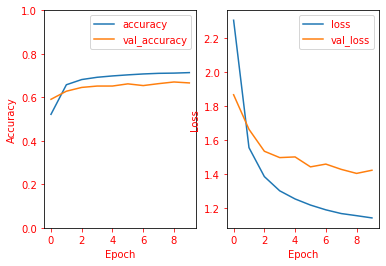

Epochs: 10
Batch size: 128
0.32061098385480497 0.2629366791100516
0.0 1.0
(128, 32, 32, 3) (128,)
307 99
Model: "simple_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_145 (InputLayer)       [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_1002 (Conv2D)         (None, 32, 32, 16)        448       
_________________________________________________________________
conv2d_1003 (Conv2D)         (None, 32, 32, 16)        2320      
_________________________________________________________________
flatten_111 (Flatten)        (None, 16384)             0         
_________________________________________________________________
dense_170 (Dense)            (None, 256)               4194560   
_________________________________________________________________
dense_171 (Dense)            (None, 43)                11051     
Total params: 4

KeyboardInterrupt: 

In [171]:
np.random.seed(5)
model = train(build_simple_modelv2, epochs=10, batch_size=128, learning_rate=1e-4)

Epochs: 10
Batch size: 128
0.32061098385480497 0.2629366791100516
0.0 1.0
(128, 32, 32, 3) (128,)
307 99
Model: "simple_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_148 (InputLayer)       [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_1010 (Conv2D)         (None, 32, 32, 16)        448       
_________________________________________________________________
conv2d_1011 (Conv2D)         (None, 32, 32, 16)        2320      
_________________________________________________________________
conv2d_1012 (Conv2D)         (None, 32, 32, 32)        4640      
_________________________________________________________________
flatten_114 (Flatten)        (None, 32768)             0         
_________________________________________________________________
dense_176 (Dense)            (None, 128)               4194432   
_______________

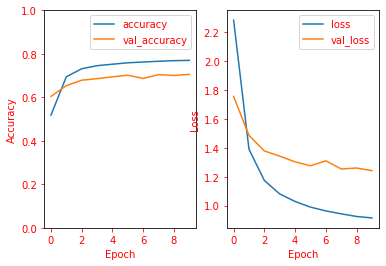

In [174]:
np.random.seed(5)
model = train(build_simple_modelv2, epochs=10, batch_size=128, learning_rate=1e-4)


Epochs: 10
Batch size: 128
0.32061098385480497 0.2629366791100516
0.0 1.0
(128, 32, 32, 3) (128,)
307 99
Model: "simple_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_154 (InputLayer)       [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_1037 (Conv2D)         (None, 32, 32, 16)        448       
_________________________________________________________________
conv2d_1038 (Conv2D)         (None, 32, 32, 16)        2320      
_________________________________________________________________
conv2d_1039 (Conv2D)         (None, 32, 32, 32)        4640      
_________________________________________________________________
conv2d_1040 (Conv2D)         (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_1041 (Conv2D)         (None, 16, 16, 64)        18496     
_______________

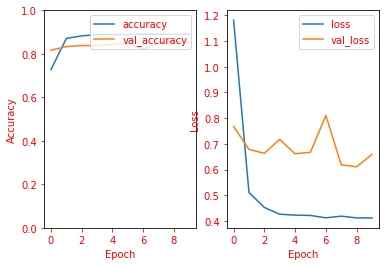

In [180]:
np.random.seed(5)
model = train(build_simple_modelv2, epochs=10, batch_size=128, learning_rate=3e-4)


Epochs: 10
Batch size: 128
0.32061098385480497 0.2629366791100516
0.0 1.0
(128, 32, 32, 3) (128,)
307 99
Model: "simple_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_166 (InputLayer)       [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_1131 (Conv2D)         (None, 32, 32, 16)        448       
_________________________________________________________________
conv2d_1132 (Conv2D)         (None, 32, 32, 16)        2320      
_________________________________________________________________
conv2d_1133 (Conv2D)         (None, 32, 32, 32)        4640      
_________________________________________________________________
conv2d_1134 (Conv2D)         (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_1135 (Conv2D)         (None, 15, 15, 64)        18496     
_______________

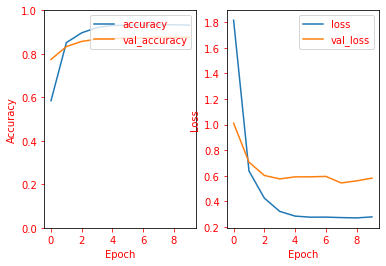

In [192]:
np.random.seed(5)
model = train(build_simple_modelv2, epochs=10, batch_size=128, learning_rate=2e-4)

In [193]:
def save_model(model, name):
    validation_generator = DataGenerator(f"{PATH_TO_DATA}/Test.csv", f"{PATH_TO_DATA}/label_names.csv", 128, input_shape)
    val_loss, val_acc = model.evaluate(validation_generator, verbose=2)
    model.save(f"./weights/val_acc_{str(val_acc)[:5]}_{name}")

In [194]:
save_model(model, "v1")

99/99 - 3s - loss: 0.5806 - accuracy: 0.8774
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./weights/val_acc_0.877_v1\assets


In [243]:
import time

def conv_layer(kernel_size=3, filters=16, strides=(1,1), padding="same",
               kernel_initializer=None,
               kernel_regularizer=None,
               activity_regularizer=None,
               bias_regularizer='zeros'
               ):
    return Conv2D(kernel_size=kernel_size, filters=filters, activation="relu", strides=strides, padding=padding,
                  kernel_initializer=kernel_initializer,
                  kernel_regularizer=kernel_regularizer,
                  activity_regularizer=activity_regularizer,
                  bias_regularizer=bias_regularizer
                  )

def build_simple_modelv3(input_size, num_classes):
    kernel_initializer= tf.keras.initializers.HeNormal()
    kernel_regularizer= tf.keras.regularizers.l2(l2=1e-3)
    activity_regularizer= None#tf.keras.regularizers.l2(l2=1e-6)
    bias_regularizer= None#tf.keras.regularizers.l2(l2=1e-6)

    inputs = Input(shape=input_size)

    x = conv_layer(kernel_size=3, filters=16,
                   kernel_initializer=kernel_initializer,
                   kernel_regularizer=kernel_regularizer,
                   activity_regularizer=activity_regularizer,
                   bias_regularizer=bias_regularizer
                   )(inputs)
    x = conv_layer(kernel_size=3, filters=16,
                   kernel_initializer=kernel_initializer,
                   kernel_regularizer=kernel_regularizer,
                   activity_regularizer=activity_regularizer,
                   bias_regularizer=bias_regularizer
                   )(x)
    x = conv_layer(kernel_size=3, filters=32,
                   kernel_initializer=kernel_initializer,
                   kernel_regularizer=kernel_regularizer,
                   activity_regularizer=activity_regularizer,
                   bias_regularizer=bias_regularizer
                   )(x)
    x = conv_layer(kernel_size=3, filters=32,
                   kernel_initializer=kernel_initializer,
                   kernel_regularizer=kernel_regularizer,
                   activity_regularizer=activity_regularizer,
                   bias_regularizer=bias_regularizer
                   )(x)

    x = conv_layer(kernel_size=3, filters=64, strides=2, padding="valid",
                   kernel_initializer=kernel_initializer,
                   kernel_regularizer=kernel_regularizer,
                   activity_regularizer=activity_regularizer,
                   bias_regularizer=bias_regularizer
                   )(x)
    x = conv_layer(kernel_size=3, filters=64,
                   kernel_initializer=kernel_initializer,
                   kernel_regularizer=kernel_regularizer,
                   activity_regularizer=activity_regularizer,
                   bias_regularizer=bias_regularizer
                   )(x)

    x = conv_layer(kernel_size=3, filters=128,
                   kernel_initializer=kernel_initializer,
                   kernel_regularizer=kernel_regularizer,
                   activity_regularizer=activity_regularizer,
                   bias_regularizer=bias_regularizer
                   )(x)
    x = conv_layer(kernel_size=3, filters=128,
                   kernel_initializer=kernel_initializer,
                   kernel_regularizer=kernel_regularizer,
                   activity_regularizer=activity_regularizer,
                   bias_regularizer=bias_regularizer
                   )(x)

    x = Flatten()(x)
    x = Dense(64, activation="relu",
              kernel_initializer=kernel_initializer,
              kernel_regularizer=kernel_regularizer,
              activity_regularizer=activity_regularizer,
              bias_regularizer=bias_regularizer)(x)
    #x = Dropout(0.5)(x)
    x = Dense(num_classes, activation="relu",
              kernel_initializer=kernel_initializer,
              kernel_regularizer=kernel_regularizer,
              activity_regularizer=activity_regularizer,
              bias_regularizer=bias_regularizer)(x)
    return Model(inputs=inputs, outputs=x, name="simple_model")


model = build_simple_modelv2(input_shape, 43)
model.summary()
del model

Model: "simple_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_207 (InputLayer)       [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_1402 (Conv2D)         (None, 32, 32, 16)        448       
_________________________________________________________________
conv2d_1403 (Conv2D)         (None, 32, 32, 16)        2320      
_________________________________________________________________
conv2d_1404 (Conv2D)         (None, 32, 32, 32)        4640      
_________________________________________________________________
conv2d_1405 (Conv2D)         (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_1406 (Conv2D)         (None, 15, 15, 64)        18496     
_________________________________________________________________
conv2d_1407 (Conv2D)         (None, 15, 15, 64)       

Epochs: 10
Batch size: 128
0.30191160713145926 0.25944010377392046
0.00784313725490196 1.0
(128, 32, 32, 3) (128,)
307 99
Model: "simple_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_169 (InputLayer)       [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_1155 (Conv2D)         (None, 32, 32, 16)        448       
_________________________________________________________________
conv2d_1156 (Conv2D)         (None, 32, 32, 16)        2320      
_________________________________________________________________
conv2d_1157 (Conv2D)         (None, 32, 32, 32)        4640      
_________________________________________________________________
conv2d_1158 (Conv2D)         (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_1159 (Conv2D)         (None, 15, 15, 64)        18496    

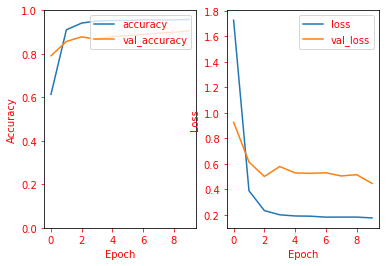

In [198]:
np.random.seed(int(time.time()))
model = train(build_simple_modelv2, epochs=10, batch_size=128, learning_rate=2e-4)

In [199]:
save_model(model, "v1_lr_2e-4_no_reg_0.95_train")


99/99 - 3s - loss: 0.4474 - accuracy: 0.9063
INFO:tensorflow:Assets written to: ./weights/val_acc_0.906_v1_lr_2e-4_no_reg_0.95_train\assets


Epochs: 10
Batch size: 128
0.31833980784696686 0.26624520595451673
0.0 1.0
(128, 32, 32, 3) (128,)
307 99
Model: "simple_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_175 (InputLayer)       [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_1203 (Conv2D)         (None, 32, 32, 16)        448       
_________________________________________________________________
conv2d_1204 (Conv2D)         (None, 32, 32, 16)        2320      
_________________________________________________________________
conv2d_1205 (Conv2D)         (None, 32, 32, 32)        4640      
_________________________________________________________________
conv2d_1206 (Conv2D)         (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_1207 (Conv2D)         (None, 15, 15, 64)        18496     
______________

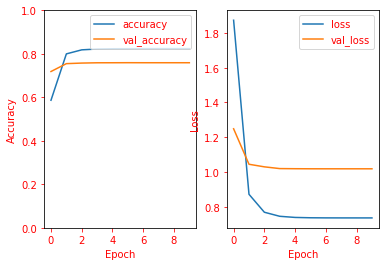

In [209]:
np.random.seed(int(time.time()))
model = train(build_simple_modelv2, epochs=10, batch_size=128, learning_rate=2e-4)

In [210]:
save_model(model, "v1_lr_2e-4_no_reg_0.82_train")


99/99 - 3s - loss: 1.0183 - accuracy: 0.7591
INFO:tensorflow:Assets written to: ./weights/val_acc_0.759_v1_lr_2e-4_no_reg_0.82_train\assets


Epochs: 5
Batch size: 128
0.32143803016812195 0.2547515152755655
0.0 1.0
(128, 32, 32, 3) (128,)
307 99
Model: "simple_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_206 (InputLayer)       [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_1394 (Conv2D)         (None, 32, 32, 16)        448       
_________________________________________________________________
conv2d_1395 (Conv2D)         (None, 32, 32, 16)        2320      
_________________________________________________________________
conv2d_1396 (Conv2D)         (None, 32, 32, 32)        4640      
_________________________________________________________________
conv2d_1397 (Conv2D)         (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_1398 (Conv2D)         (None, 15, 15, 64)        18496     
________________

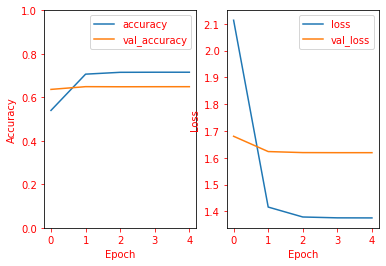

In [242]:
####################### regularization ##################################
np.random.seed(int(time.time()))
model = train(build_simple_modelv3, epochs=5, batch_size=128, learning_rate=2e-4)

In [ ]:
save_model(model, "v2_lr_2e-4_reg_")

In [ ]:
validation_generator = DataGenerator(f"{PATH_TO_DATA}/Test.csv", f"{PATH_TO_DATA}/label_names.csv", 128, input_shape)
new_model = tf.keras.models.load_model("weights/val_acc_0.906_v1_lr_2e-4_no_reg_0.95_train")

new_model.summary()

new_model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

val_loss, val_acc = new_model.evaluate(validation_generator, verbose=2)
print(val_acc, val_loss)

### **Extra credit**

Implement the learning rate scheduler described in the [paper](!https://arxiv.org/pdf/1608.03983.pdf) "SGDR: Stochastic gradient descent with warm restarts". You are mostly interested in Section 3 from the paper.

In [ ]:
# TODO optional extra credit assignment

## Ensembles
 
Pick your N (3 or 5) of the networks that you've trained and create an ensemble. The prediction of the ensemble is just the average of the predictions of the N networks.
 
Evaluate the ensemble (your accuracy should boost by at least 1.5%).


In [ ]:
# TODO your code here
# feed the images to the three networks, average the logits of the networks and 

# evaluate the ensemble

# Transfer learning and fine-tuning
 
In the _tensorflow.keras.applications_ module you can find implementations of several well known CNN architectures (most of the models that we covered during the lecture), as well as the pretrained weights of these models on the ImageNet dataset. 
You can use this module to apply transfer learning and fine-tuning for your classification problem. [Here](!https://keras.io/api/applications/) you can find a comprehensive table with the size of the models, number of parameters, top-1 and top-5 accuracy on the ImageNet dataset.
 
When using deep neural networks, transfer learning is the norm, not the exception.  Transfer learning refers to the situation where what has been learned in one setting is used to improve generalization in another setting.
The transfer learning pipeline can be summarized as follows:
- get the weights of a model trained on similar classification problem (for which more training data is available);
- remove the final classification layer;
- freeze the weights (don't update them during the training process); these layers would be used as a feature extractor;
- add a/some trainable layers over the frozen layers. They will learn how the extracted features can be used to distinguish between the classes of your classification problem.
- train these new layers on your dataset.
 
Next, you can also use fine-tuning. During fine-tuning you will unfreeze the model (or a larger part of the model), and train it on the new data with a very low learning rate.
 
Follow this [tutorial](!https://keras.io/guides/transfer_learning/) to solve this exercise.
 
When following the tutorial
- pay attention to the discussion about the BatchNormalization layers;
- you can skip the section "Transfer learning & fine-tuning with a custom training loop", we'll cover this in the next laboratory;
- pay attention to the loss that you will be using when training your model. In the tutorial the loss is the binary cross entropy loss which is suitable for binary classification problems. If your problem is multi-class you should use the categorical cross entropy loss.
- use the pre-processing required by the network architecture that you chose.
 
To sum up, pick a neural network architecture from the _tensorflow.keras.applications_ module and use transfer learning and fine tuning to train it to classify the images from your dataset (you should use the custom DataGenerator that you wrote for this). 
 Briefly describe the key features of the neural network architecture that you chose and why you chose it.
 
Apply transfer learning (with at least one config for the hyperparameters) and report the performance. Apply fine-tuning  (with at least one config for the hyperparameters) and report the performance.
Finally, plot the performance of the model when you used only transfer learning and the performance of the model when you also used fine-tuning on the same plot.
 
I chose the architecture <font color='red'> TODO </font> , because <font color='red'> TODO </font> .
The key features of this architecture are
- <font color='red'> TODO  </font> 
- <font color='red'> TODO  </font> 
- <font color='red'> TODO  </font> 
 
How does the performance of this fine-tuned model compare to the performance of the network that you trained from scratch?
 




In [ ]:
# TODO your transfer-learning and fine-tuning step